In [1]:
import pickle
import time
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import statsmodels.api as sm
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import seaborn as sns

from tdamapper.plot import MapperLayoutInteractive, MapperLayoutStatic

from functions import *
from chi import *
from regressionP import *
from models import *

In [2]:
data1 = pd.read_csv("./Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("./Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("./Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("./Data/NPA_TMA2_4.csv", low_memory=False)[:-2]
dataA2 = pd.concat([data1, data2, data3, data4], ignore_index=True)

dataA1 = pd.read_csv("./Data/NPA_TMA1.csv")[:-2]

def preprocess(input_data, select_lst, sample = 592):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    dataA = sample_data[select_lst]
    
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

In [3]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

def plot_bar_comparison(df1, df2, feature):
    plt.figure(figsize=(14, 6))
    
    df1_counts = df1[feature].value_counts(normalize=True).reset_index()
    df2_counts = df2[feature].value_counts(normalize=True).reset_index()
    
    df1_counts['Source'] = 'Link'
    df2_counts['Source'] = 'Outlier'

    combined_counts = pd.concat([df1_counts, df2_counts])
    combined_counts.columns = [feature, 'Frequency', 'Source']

    ax = sns.barplot(data=combined_counts, x=feature, y='Frequency', hue='Source')
    plt.title(f'{feature} 頻率')
    plt.xticks(rotation=30)

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2%}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha = 'center', va = 'bottom', 
                    fontsize = 10, color = 'black', xytext = (0, 5),
                    textcoords = 'offset points')
    plt.show()

In [4]:
# List of columns to select
select_lst = [
    '路面狀況-路面狀態名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
    '死亡受傷人數'
]

dist_dfA1 = preprocess(dataA1, select_lst, sample = 592)
dist_dfA2 = preprocess(dataA2, select_lst, sample = 11840) # 120420

rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)
rbind_data = process_age(rbind_data)
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)

dist_df = process_data(rbind_data)
scaler = StandardScaler()

In [5]:
with open('CalculatedData/mapper_graph1.pkl', 'rb') as f:
    mapper_graph1 = pickle.load(f)
    
mapper_plot1 = MapperLayoutInteractive(
    mapper_graph1,
    colors = dist_df[['速限-第1當事者']].to_numpy(),
    cmap = 'jet',
    # agg = np.nanmean,
    agg = most_frequent_nonan,
    dim = 3,
    iterations = 30,
    seed = 6,
    width = 800,
    height = 500)

# fig_mean1 = mapper_plot1.plot()
# fig_mean1.show(config={'scrollZoom': True})

In [6]:
x = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
y = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
z = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

import re
data_tuple = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

data = []
for item in data_tuple:
    color = int(re.search(r'color: (-?\d+)', item).group(1))
    node = int(re.search(r'node: (\d+)', item).group(1))
    size = int(re.search(r'size: (\d+)', item).group(1))
    data.append({'color': color, 'node': node, 'size': size})
component_info = pd.DataFrame(data)

full_info = pd.concat([component_info, threeDimData], axis=1)

mp_content_origin = vars(mapper_plot1._MapperLayoutInteractive__graph)['_node']

mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
mp_content.reset_index(inplace=True)
mp_content.rename(columns={'index': 'node'}, inplace=True)

full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

In [7]:
calinski_data = get_calinski_from_db(full_info, 0.045)

label_0 = full_info[full_info['label'] == 0]
label_1 = full_info[full_info['label'] == 1]
label_2 = full_info[full_info['label'] == 2]
label_out = full_info[(full_info['label'] != 1) & (full_info['label'] != 2) & (full_info['label'] != 0)]

count_0 = get_count_dict(label_0)
count_1 = get_count_dict(label_1)
count_2 = get_count_dict(label_2)
count_out = get_count_dict(label_out)

full_0 = rbind_data.loc[count_0.keys()]
full_1 = rbind_data.loc[count_1.keys()]
full_2 = rbind_data.loc[count_2.keys()]

# 離群值不需要被處理
full_out = rbind_data.loc[count_out.keys()]

lst01 = list(count_0.keys() & count_1.keys())
lst02 = list(count_0.keys() & count_2.keys())
lst12 = list(count_1.keys() & count_2.keys())
lsto0 = list(count_out.keys() & count_0.keys())
lsto1 = list(count_out.keys() & count_1.keys())
lsto2 = list(count_out.keys() & count_2.keys())

# 將重複的key另外拉出進行分析，這裡drop是為了符合卡方的獨立性前提假設
full_01 = full_0.loc[lst01]
full_02 = full_0.loc[lst02]
full_12 = full_1.loc[lst12]

full_combine = pd.concat([full_01, full_02, full_12], axis=0) # full_out
full_combine = full_combine.reset_index()
full_combine = full_combine.drop_duplicates(subset='index', keep='first')
full_combine = full_combine.drop(['受傷', '死亡', 'index'], axis=1)

In [9]:
full_combine.shape

(220, 29)

In [11]:
full_out.shape

(131, 31)

In [8]:
select_lst = [
    '路面狀況-路面狀態名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
]

full_combine['label'] = 1
full_out['label'] = 0

labeled_data = pd.concat([full_combine, full_out])
labeled_data.reset_index(drop=True, inplace=True)

def get_clusterN_logit(cluster_data, lst):
    scaler = StandardScaler()
    
    c0_for_lm = process_data(cluster_data)
    c0_for_lm_X = pd.DataFrame(scaler.fit_transform(c0_for_lm), columns=c0_for_lm.columns).reset_index(drop=True, inplace=False)
    # label設定
    c0_for_lm_y = cluster_data.apply(lambda row: 1 if row['label'] != 0 else 2, axis=1)
    # c0_for_lm_y = cluster_data['label']
        
    c0_for_lm_X = c0_for_lm_X[lst]
    
    return c0_for_lm_X, c0_for_lm_y


X, y = get_clusterN_logit(labeled_data, select_lst)

In [9]:
matrix_svc, score_svc, cm_svc = svc_cm_with_grid_search(X, y)
print(cm_svc)

[[39  1]
 [ 5 35]]


In [10]:
matrix_logistic, score_logistic, cm_logistic = logistic_cm_gridsearch(X, y)
print(cm_logistic)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\USER\anaconda3\lib\

[[39  1]
 [ 4 36]]


C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [12]:
print(score_svc)
print(score_logistic)

0.925
0.9375


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y.replace(2, 0), test_size=0.2, random_state=42)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

print(result.summary())

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
accuracy = log_reg.score(X_test, y_test)

print(f"Accuracy: {accuracy:.2f}")

Optimization terminated successfully.
         Current function value: 0.057319
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  280
Model:                          Logit   Df Residuals:                      252
Method:                           MLE   Df Model:                           27
Date:                Sat, 29 Jun 2024   Pseudo R-squ.:                  0.9138
Time:                        20:52:49   Log-Likelihood:                -16.049
converged:                       True   LL-Null:                       -186.23
Covariance Type:            nonrobust   LLR p-value:                 5.998e-56
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
路面狀況-路面狀態名稱                 0.5045      0.838      0.602      0.547      -1.138  

In [20]:
p_values = result.pvalues
significant_factors = p_values[p_values < 0.05]
significant_factors.sort_values()

車道劃分設施-分道設施-快慢車道間名稱    0.005649
道路類別-第1當事者-名稱          0.007971
事故類型及型態大類別名稱           0.013050
速限-第1當事者               0.016555
車道劃分設施-分道設施-路面邊線名稱     0.020959
dtype: float64

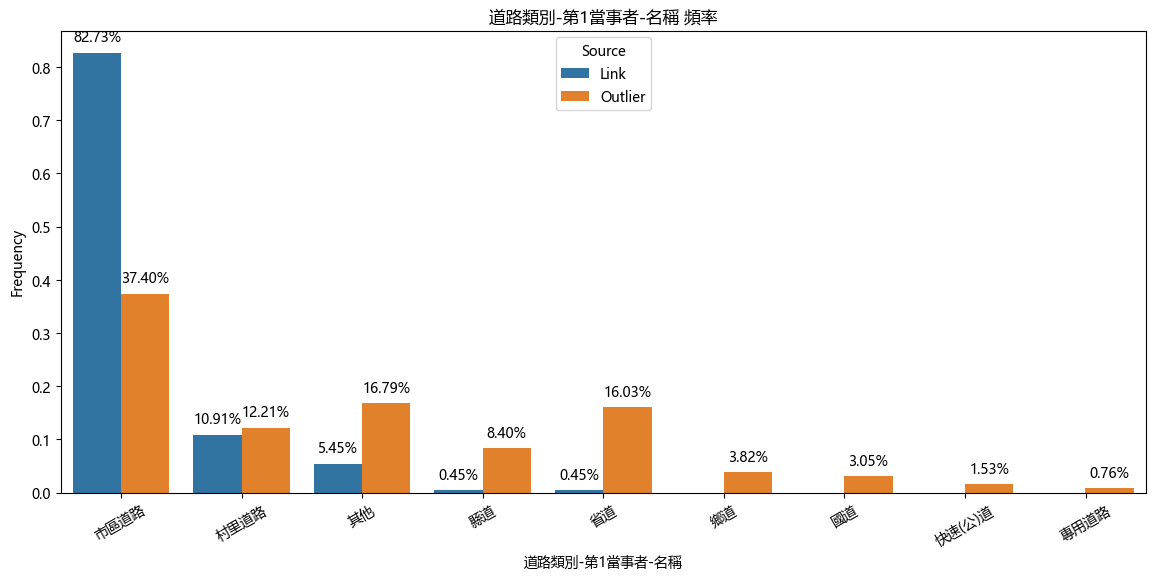

In [14]:
plot_bar_comparison(full_combine, full_out, '道路類別-第1當事者-名稱')

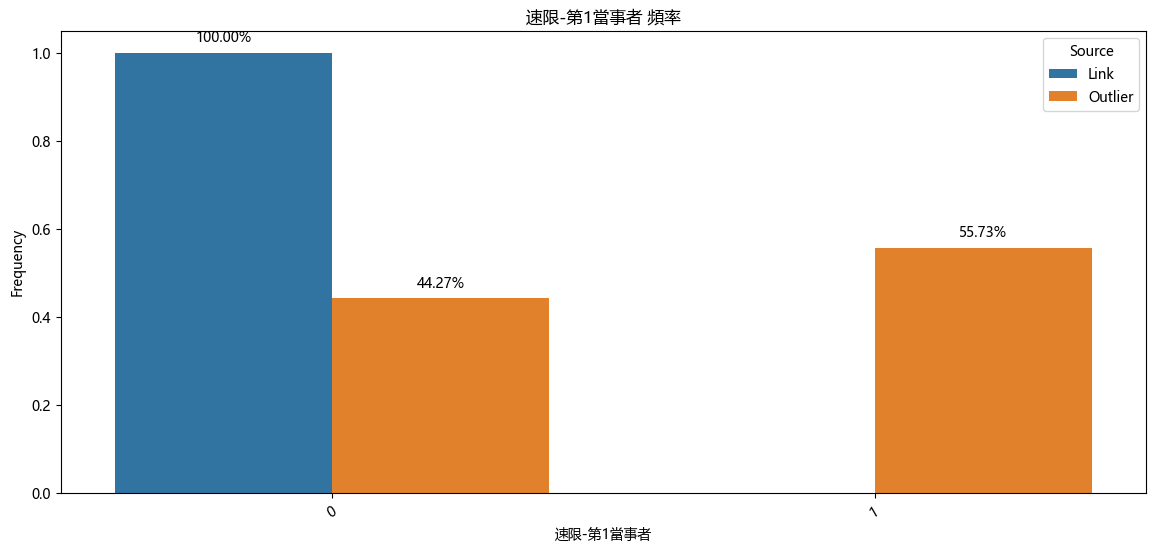

In [16]:
plot_bar_comparison(full_combine, full_out, '速限-第1當事者')

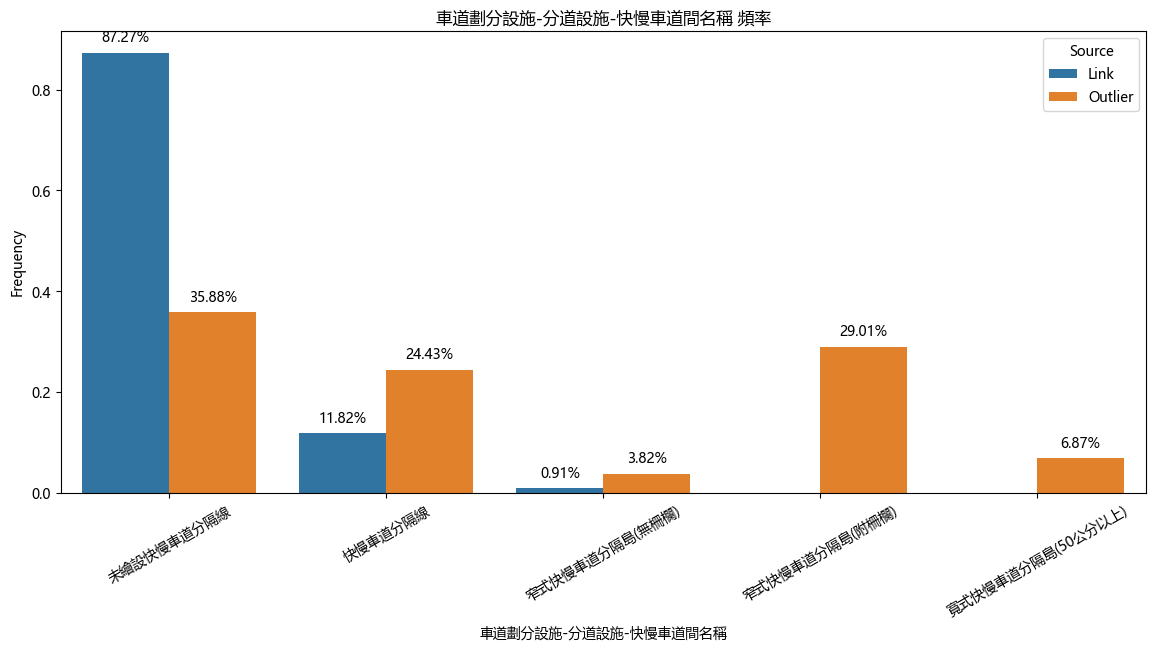

In [220]:
plot_bar_comparison(full_combine, full_out, '車道劃分設施-分道設施-快慢車道間名稱')

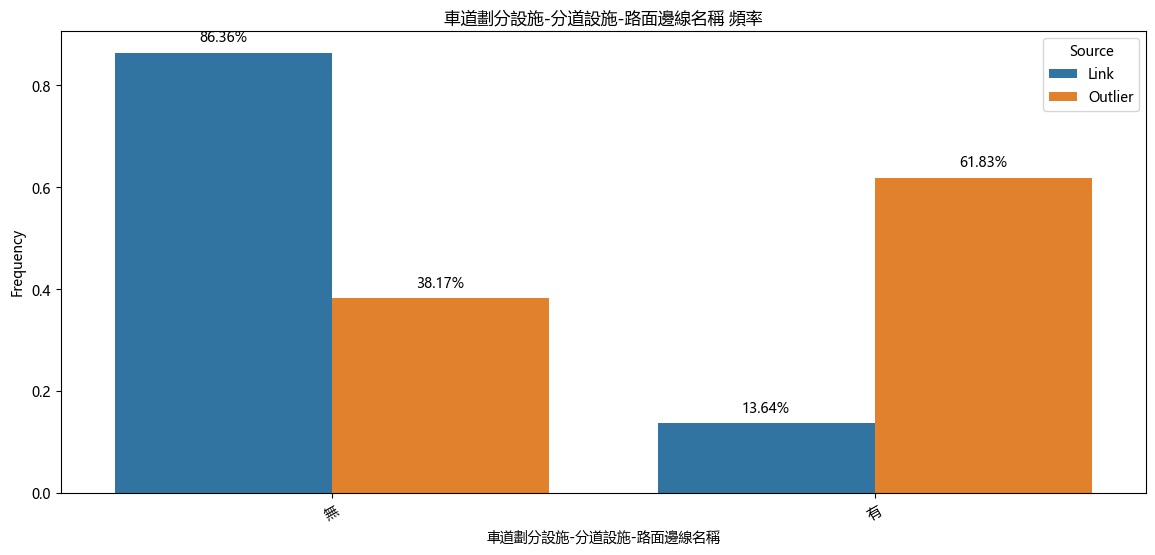

In [215]:
plot_bar_comparison(full_combine, full_out, '車道劃分設施-分道設施-路面邊線名稱')

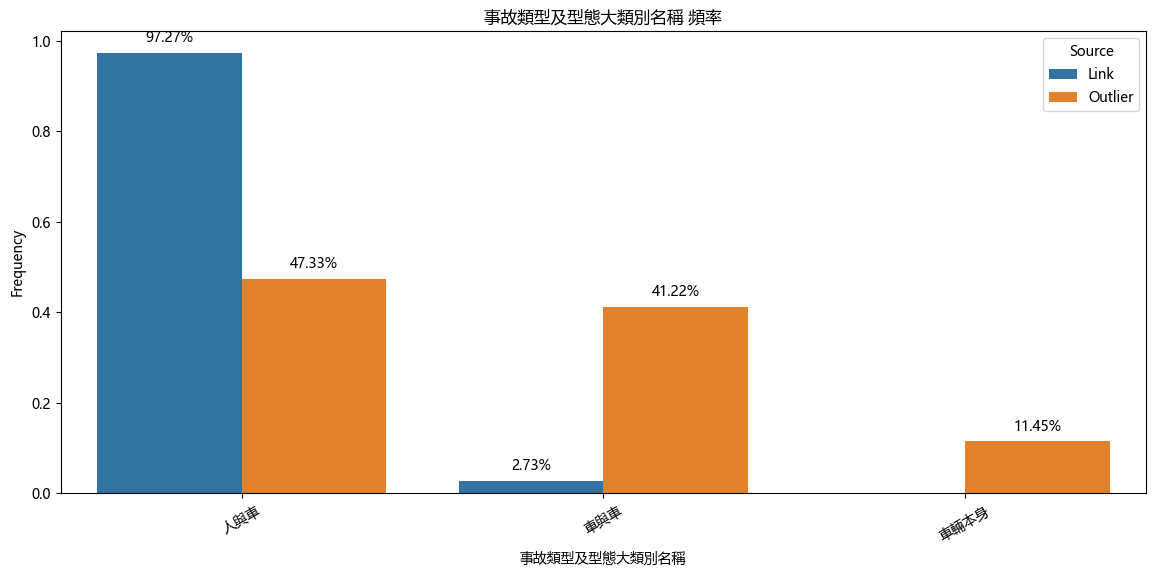

In [17]:
plot_bar_comparison(full_combine, full_out, '事故類型及型態大類別名稱')

In [22]:
full_combine['事故類型及型態大類別名稱'].value_counts()

人與車    214
車與車      6
Name: 事故類型及型態大類別名稱, dtype: int64

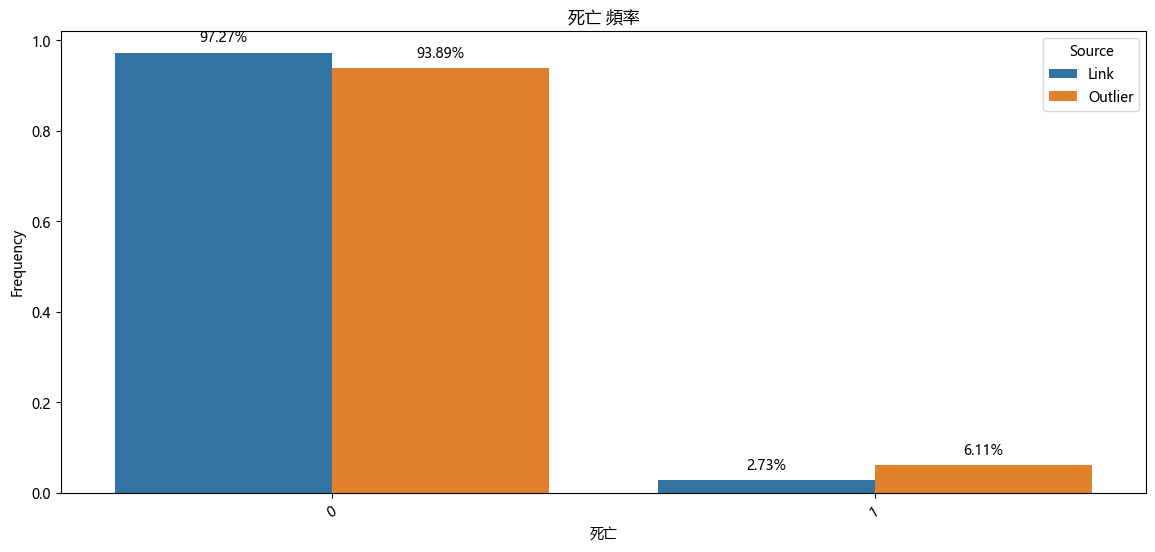

In [244]:
full_combine = pd.concat([full_01, full_02, full_12], axis=0) # full_out
full_combine = full_combine.reset_index()
full_combine = full_combine.drop_duplicates(subset='index', keep='first')
full_combine
full_out

plot_bar_comparison(full_combine, full_out, '死亡')